# CC3182 – Visión por Computadora
# Laboratorio 1

## Integrantes:
 - Francis Aguilar
 - César Lopez
 - Jose Marchena

Usted ha sido contratado como Ingeniero de Visión Computacional Junior en "AutonoVision", una startup que
desarrolla sistemas de navegación para robots de almacén.
El equipo de hardware ha instalado nuevas cámaras, pero las imágenes llegan con mucho ruido térmico
debido a las condiciones de luz del almacén. El módulo actual de detección de obstáculos está fallando:
detecta la textura del suelo de concreto como si fueran "bordes" de obstáculos, frenando el robot
innecesariamente.
Su Director de Proyecto le ha asignado la tarea de construir un pipeline de pre-procesamiento robusto desde
cero para entender el problema a nivel matemático y ajustar los parámetros óptimos para el despliegue.

----

## Task 1 - Análisis Teórico y Analítico
Considerando el escenario previamente planteado, conteste:
1. Su jefe sugiere usar un filtro de media (Box Filter) de 7x7 para eliminar el ruido rápido. Usted cree que es una mala idea. Explique matemáticamente y con un diagrama visual (dibujado) por qué un Box Filter de ese tamaño es perjudicial para la detección precisa de la posición de un obstáculo comparado con un filtro Gaussiano del mismo tamaño.

**R\\**

Un Box Filter asi de grande aplica un alizamiento extremo sobre las imagenes que procesa y causa perdida en el contraste entre bordes y el fenomeno de Ringing en las imagenes luego de un par de iteraciones.
Ademas de los artefactos que causa, el filtro de media tiende a perder detalle de formas en su alizamiento, teniendo un sesgo a hacer ver todo cuadrado, lo que impediria la deteccion precisa de obstaculos ya que complicaria su deteccion optima

Mientras tanto, un filtro gausiano si mantiene la curvatura de las imagenes en su alizamiento, lo que puede llevar a mejores resultados en la deteccion de objetos

Filtro Gausiano:
![image.png](./gauss.png)

Filtro de Media
![image.png](./box.png)

2. Al realizar la convolución en los bordes de la imagen (por ejemplo, en el píxel 0,0), el kernel "se sale"
de la imagen.

A. Si el robot navega por pasillos oscuros con luces brillantes al final, ¿por qué el Zero-
Padding podría generar falsos positivos de bordes en la periferia de la imagen?

- El Zero Padding introduce valores artificiales (0) fuera de la imagen. En escenarios como pasillos oscuros con luces brillantes al fondo, esto provoca un salto brusco de intensidad entre el borde real de la imagen y el padding. Esto hace que el robot pueda detectar obstaculos falsos cerca de los bordes de la imagen.

B. ¿Qué estrategia de padding (Reflect, Replicate, Wrap) recomendaría para evitar esto y por qué?
- Es mejor reflect, ya que mantiene la continuidad de intensidad, por ejemplo, se usa de referencia lo que ya estaba antes, asi no hay posibilidad de bordes o contraste inesperado.

3. Dada la siguiente sub-imagen I de 3x3 y el kernel K:
$$
I = 
\begin{pmatrix}
10 & 10 & 10 \\
10 & 10 & 10 \\
0 & 10 & 10
\end{pmatrix}
$$

$$
K = 
\begin{pmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{pmatrix}
$$
### a. Calcule el valor del píxel central resultante de la convolución

 **R\\**
r = 10*0 + 10*1 + 10*0 + 10*1 + 10*-4 + 10*1 + 10*0 + 10 + 10*0
= 10 + 10 - 40 + 10 + 10 = 0

El producto punto entre estas dos matriceses 0.


### b. ¿Qué tipo de estructura detecta este filtro K (conocido como Laplaciano)?

Similar al filtro de sobel, el laplaciano detecta cambio drastico de un pixel con sus vecinos. La diferencia es que el Laplaciano detecta cambios o bordes sin importar la direccion, pues responde igual a todos.




----

## Task 2 – Práctica

### Ejercicio 1: Convolución 2D Genérica
Escriba una función mi_convolucion(imagen, kernel, padding_type='reflect'), Considerando
lo siguiente:
- Restricción 1: La función debe manejar imágenes en escala de grises.
- Restricción 2: Debe implementar el padding manualmente antes de operar.
- Reto de optimización: Intente no usar 4 bucles for anidados. Investigue cómo usar slicing de NumPy o np.einsum para hacerlo vectorizado, o al menos reduzca a 2 bucles.
- Nota: Recuerde que matemáticamente la convolución invierte el kernel. Implemente el "flip" del kernel dentro de la función.


In [ ]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def mi_convolucion(img, kernel, padding_type='reflect'):
    """
    padding_type: ['reflect', 'zeros', 'none']
    """
    # Reflext kernel
    kernel = np.flip(kernel)
    
    # Convert to np array
    raw_array = np.array(img.convert('L'))
    r_h, r_w = raw_array.shape
    k_h, k_w = kernel.shape
    
    # Padding zero/reflect
    if padding_type == 'reflect':
        img_array = np.pad(raw_array, pad_width=k_h\\2, mode='reflect')
    elif padding_type == 'zeros': 
        img_array = np.pad(raw_array, pad_width=k_h\\2)
    else:
        img_array = np.copy(raw_array)
        
    # actual convolution
    o_h, o_w = img_array.shape[0] - k_w+1, img_array.shape[1] - k_h+1
    output = np.zeros((o_h, o_w))
    for i in range(o_h):
        for j in range(o_w):
            window = img_array[i:i+k_w, j:j+k_w] # slice
            output[i][j] = np.sum(window * kernel) # np sum
            
    return output


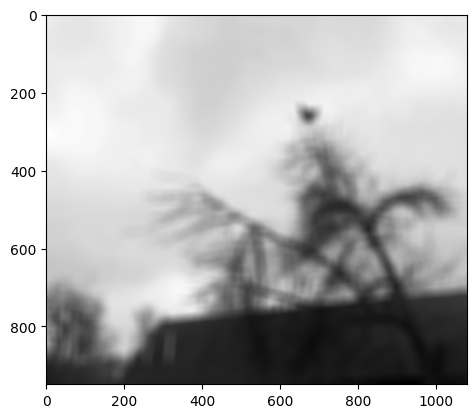

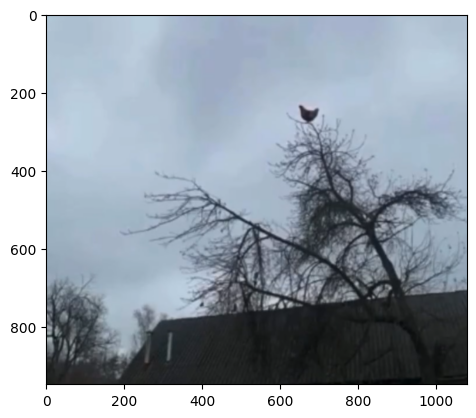

In [2]:
# Ejemplo
test = Image.open('./test.png')
# Box shaddow kernel for test
kernel = np.ones((30,30))/900

# show
rslt = mi_convolucion(test, kernel, padding_type='reflect')
plt.imshow(rslt, cmap='gray')
plt.show()
plt.imshow(test, cmap='gray')
plt.show()

### Ejercicio 2: Generador de Gaussianos
Escriba una función generar_gaussiano(tamano, sigma). Para ello considere:
• La función debe devolver una matriz cuadrada de tamano x tamano con los coeficientes de una
distribución Gaussiana 2D centrada.
• Importante: Asegúrese de que la suma de todos los elementos de la matriz sea igual a 1.0
(Normalización).

In [ ]:
import numpy as np

def generar_gaussiano(tamano, sigma):
    assert tamano % 2 == 1, "El tamaño debe ser impar"
    
    k = tamano // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    
    gauss = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Normalizacion
    gauss = gauss / np.sum(gauss)
    
    return gauss


### Ejercicio 3: Pipeline de Detección de Bordes (Sobel)
Cree una función detectar_bordes_sobel(imagen).. Para ello considere:
• Aplique los kernels de Sobel 𝐺𝑥 y 𝐺𝑦 usando su función mi_convolucion
• Calcule y retorne dos matrices:
o Magnitud del gradiente: 
$$
G =
\sqrt{ Gx^2 + Gy^2}
$$
2 (Normalizada a 0-255 para visualizar)
o Dirección del gradiente: θ=arctan2(Gy,Gx) (En radianes o grados)



In [25]:
def detectar_bordes_sobel(img):
    SOBEL_GX = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype=np.float32)

    SOBEL_GY = np.array([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ], dtype=np.float32)

    Gx = mi_convolucion(img, SOBEL_GX)
    Gy = mi_convolucion(img, SOBEL_GY)

    G = np.sqrt(Gx**2 + Gy**2)
    G_norm = (G / G.max()) * 255
    G_norm = G_norm.astype(np.uint8)

    theta = np.arctan2(Gy, Gx)

    return G_norm, theta


In [24]:
from PIL import Image

img = Image.open("imagen.jpg")

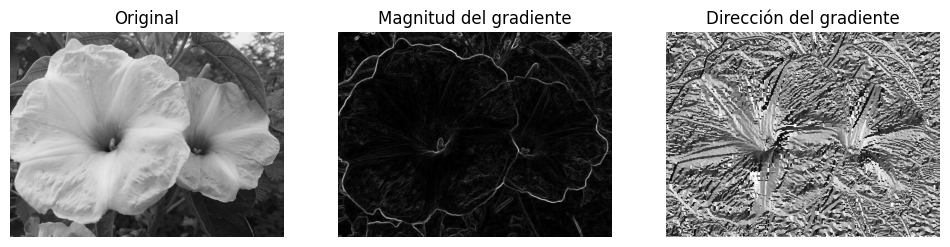

In [26]:
G, theta = detectar_bordes_sobel(img)

# Visualización
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Magnitud del gradiente")
plt.imshow(G, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Dirección del gradiente")
plt.imshow(theta, cmap='gray')
plt.axis('off')

plt.show()


----

## Task 3 – Evaluación de Ingenería y Criterio

### Experimento A: El efecto de Sigm (σ)
Cargue una imagen con ruido (agregue ruido "Sal y Pimienta" o Gaussiano artificialmente a una foto limpia
si es necesario).
1. Genere 3 versiones de detección de bordes (Magnitud Sobel) variando el pre-procesamiento
Gaussiano:
a. Sin suavizado.
b. Gaussiano 𝜎 = 1 (kernel sugerido 5x5).
c. Gaussiano 𝜎 = 5 (kernel sugerido 31x31).
2. Análisis: Muestre las tres imágenes de bordes resultantes. ¿Qué pasa con los bordes finos cuando σ
es muy alto? ¿Qué pasa con la textura del suelo cuando no hay suavizado? Como ingeniero, ¿cuál
elegiría para detectar pallets grandes ignorando grietas pequeñas en el suelo?

### Experimento B: Histéresis Manual (Simulación de Canny)
Usted ha calculado la Magnitud del Gradiente en el paso 3.3. Ahora implemente una función simple de
umbralización umbral_simple(magnitud, T) y compare visualmente con cv2.Canny.


In [ ]:
def umbral_simple(magnitud, T):
    thresh_matrix = np.where(magnitud > T,1, 0)
    return np.astype(thresh_matrix, np.uint8)

In [ ]:
test = Image.open('./test.png').convert('L')

Gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])
Gy = np.array([[-1, -2, -1],
               [ 0,  0,  0],
               [ 1,  2,  1]])

Mx = mi_convolucion(test, Gx, padding_type='reflect')
My = mi_convolucion(test, Gx, padding_type='reflect')
M = np.multiply(Mx, Mx) + np.multiply(My, My)
M = np.sqrt(M)

Text(0.5, 1.0, 'Cv2-Canny (50)')

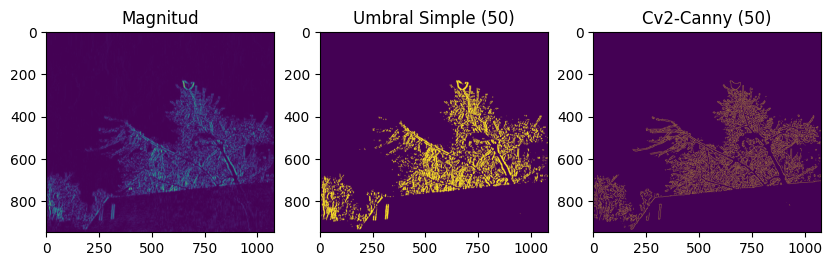

In [ ]:
import cv2
fig, ax = plt.subplots(1, 3, figsize=((10,5)))

ax[0].imshow(M)
ax[0].set_title("Magnitud")

T = umbral_simple(M, 50)    
ax[1].imshow(T)
ax[1].set_title("Umbral Simple (50)")

img = np.array(test, dtype=np.uint8)
C = cv2.Canny(img, threshold1=50, threshold2=50)
ax[2].imshow(C)
ax[2].set_title("Cv2-Canny (50)")


1. Intente encontrar un valor T único que limpie el ruido pero mantenga los bordes.
2. Observe el resultado: ¿Se rompen las líneas de los bordes?
3. Pregunta Crítica: Explique por qué un simple umbral de corte (Thresholding) nunca será tan efectivo
como el método de Histéresis usado en Canny. ¿Qué problema específico resuelve la conectividad
de la histéresis en el contexto de un robot moviéndose y vibrando (lo que causa cambios leves de
iluminación en los bordes)?